<a href="https://colab.research.google.com/github/5ohyun/Stock_SSPharm/blob/main/%EC%82%BC%EC%84%B1%EC%A0%9C%EC%95%BD_%EC%9D%BC%EC%A3%BC%EC%9D%BC_%EC%98%88%EC%B8%A1_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # 1. 전처리 작업

## (1) 데이터 병합

주식, 공매도, 배당, 금 가격, 코스피, 환율 데이터를 각 날짜 기준으로 병합(merge)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install optuna

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [54]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm
from datetime import datetime
import optuna
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from tqdm import tqdm
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU


plt.rc('font', family='NanumBarunGothic') 

In [4]:
os.chdir("/content/drive/MyDrive/팀프로젝트/삼성제약")

1. 제약 데이터

In [5]:
stock5=pd.read_csv("삼성제약 15년도.csv",encoding='UTF-8')
stock6=pd.read_csv("삼성제약 16년도.csv",encoding='UTF-8')
stock7=pd.read_csv("삼성제약 17년도.csv",encoding='UTF-8')
stock8=pd.read_csv("삼성제약 18년도.csv",encoding='UTF-8')
stock9=pd.read_csv("삼성제약 19년도.csv",encoding='UTF-8')

stock = pd.DataFrame()

for i in [stock5, stock6, stock7, stock8, stock9] : 
  i=i.sort_values(by='년/월/일',ascending=True)
  i = i.reset_index(drop=True)
  stock=pd.concat([stock,i])

stock = stock.reset_index(drop=True)
stock['년/월/일']=stock['년/월/일'].astype(str).str.replace('/',"-")


for i in ['종가', '거래량(주)', '거래대금(원)', '시가', '고가', '저가', '시가총액(백만)','상장주식수(주)'] :
  stock[i]=stock[i].str.replace(",", "").astype(float)


stock=stock[['년/월/일', '종가', '거래량(주)', '거래대금(원)', '시가', '고가', '저가', '시가총액(백만)','상장주식수(주)']]

stock=stock.rename(columns={'년/월/일':'date','종가':'c_price'})

stock

,date,c_price,거래량(주),거래대금(원),시가,고가,저가,시가총액(백만),상장주식수(주)
0,2015-01-02,2350.0,131029.0,3.064134e+08,2280.0,2400.0,2280.0,53279.0,22671867.0
1,2015-01-05,2340.0,83185.0,1.937542e+08,2370.0,2385.0,2280.0,53052.0,22671867.0
2,2015-01-06,2380.0,72097.0,1.687488e+08,2300.0,2380.0,2300.0,53959.0,22671867.0
3,2015-01-07,2395.0,81393.0,1.953211e+08,2395.0,2420.0,2375.0,54299.0,22671867.0
4,2015-01-08,2390.0,60837.0,1.452567e+08,2400.0,2415.0,2370.0,54186.0,22671867.0
...,...,...,...,...,...,...,...,...,...
1202,2019-11-25,4220.0,1908892.0,8.178295e+09,4295.0,4385.0,4210.0,248955.0,58994130.0
1203,2019-11-26,4390.0,7224166.0,3.198747e+10,4225.0,4610.0,4225.0,258984.0,58994130.0
1204,2019-11-27,4235.0,2675268.0,1.156499e+10,4395.0,4470.0,4235.0,249840.0,58994130.0
1205,2019-11-28,4240.0,3754301.0,1.634647e+10,4225.0,4570.0,4220.0,250135.0,58994130.0


2. 공매도

In [6]:
pubsale=pd.read_csv("삼성제약 공매도.csv",encoding='UTF-8')
pubsale=pubsale.rename(columns={'일자':'date','공매도거래량':'pubsale'})

pubsale['pubsale']=pubsale['pubsale'].str.replace(",", "").astype(float)
pubsale['공매도거래대금']=pubsale['공매도거래대금'].str.replace(",", "").astype(float)

pubsale = pubsale.reset_index(drop=True)

pubsale=pubsale[['date','pubsale','공매도거래대금']]

pubsale

,date,pubsale,공매도거래대금
0,2015-01-02,61.0,1.419700e+05
1,2015-01-05,723.0,1.686620e+06
2,2015-01-06,315.0,7.391900e+05
3,2015-01-07,520.0,1.245855e+06
4,2015-01-08,187.0,4.470000e+05
...,...,...,...
1202,2019-11-25,46059.0,1.974867e+08
1203,2019-11-26,255034.0,1.126076e+09
1204,2019-11-27,110546.0,4.784162e+08
1205,2019-11-28,83407.0,3.630848e+08


3. 배당

In [7]:
div5=pd.read_csv("삼성제약 배당 15년도.csv",encoding='UTF-8')
div6=pd.read_csv("삼성제약 배당 16년도.csv",encoding='UTF-8')
div7=pd.read_csv("삼성제약 배당 17년도.csv",encoding='UTF-8')
div8=pd.read_csv("삼성제약 배당 18년도.csv",encoding='UTF-8')
div9=pd.read_csv("삼성제약 배당 19년도.csv",encoding='UTF-8')

div = pd.DataFrame()

for i in [div5,div6,div7,div8,div9] : 
  i = i.sort_values(by='일자',ascending=True)
  i = i.reset_index(drop=True)
  div=pd.concat([div,i])

div = div.reset_index(drop=True)
div=div.rename(columns={'일자':'date','종가':'배당종가'})

div['date']=div['date'].astype(str).str.replace('/',"-")


for i in ['배당종가','BPS','PBR'] : 
  div[i]=div[i].astype(str).str.replace(",", "").astype(float)

div=div[['date','배당종가','BPS','PBR']]

div

,date,배당종가,BPS,PBR
0,2015-01-02,2350.0,1610.0,1.46
1,2015-01-05,2340.0,1610.0,1.45
2,2015-01-06,2380.0,1610.0,1.48
3,2015-01-07,2395.0,1610.0,1.49
4,2015-01-08,2390.0,1610.0,1.48
...,...,...,...,...
1202,2019-11-25,4220.0,2261.0,1.87
1203,2019-11-26,4390.0,2261.0,1.94
1204,2019-11-27,4235.0,2261.0,1.87
1205,2019-11-28,4240.0,2261.0,1.88


4.금 가격

In [8]:
gold=pd.read_csv("일자별 금시세.csv",encoding='UTF-8')
gold=gold.sort_values(by='년/월/일',ascending=True)
gold = gold.reset_index(drop=True)
gold=gold.rename(columns={'년/월/일':'date','원/g 종가':'gold','원/g 시가':'gold_start'})

gold['gold_start']=gold['gold_start'].str.replace(",", "").astype(float)
gold['gold']=gold['gold'].str.replace(",", "").astype(float)

gold

,date,gold,gold_start
0,2015-01-02,42300.0,42300.0
1,2015-01-05,42680.0,42400.0
2,2015-01-06,42710.0,42700.0
3,2015-01-07,42970.0,43190.0
4,2015-01-08,42890.0,43000.0
...,...,...,...
1200,2019-11-25,55150.0,55340.0
1201,2019-11-26,55110.0,54990.0
1202,2019-11-27,55220.0,55290.0
1203,2019-11-28,55210.0,55140.0


5.코스피

In [9]:
kospi=pd.read_csv("코스피지수 의약품.csv",encoding='UTF-8',header=None)
kospi=kospi.rename(columns={0:'date',1:'kospi'})
kospi=kospi.drop(0)
kospi=kospi.drop(1)
kospi = kospi.reset_index(drop=True)
#kospi['년/월/일']=kospi['년/월/일'].astype(str).str.replace('-',"/")
kospi['kospi']=kospi['kospi'].str.replace(",", "").astype(float)
kospi

,date,kospi
0,2015-01-02,4464.08
1,2015-01-05,4481.14
2,2015-01-06,4468.42
3,2015-01-07,4450.86
4,2015-01-08,4445.84
...,...,...
1202,2019-11-25,10343.65
1203,2019-11-26,10343.92
1204,2019-11-27,10485.23
1205,2019-11-28,10404.80


6. 환율 데이터

In [10]:
exrate5=pd.read_csv("환율 15년도.csv",encoding='UTF-8')
exrate6=pd.read_csv("환율 16년도.csv",encoding='UTF-8')
exrate7=pd.read_csv("환율 17년도.csv",encoding='UTF-8')
exrate8=pd.read_csv("환율 18년도.csv",encoding='UTF-8')
exrate9=pd.read_csv("환율 19년도.csv",encoding='UTF-8')

exrate = pd.DataFrame()

for i in [exrate5,exrate6,exrate7,exrate8,exrate9] : 
  i = i.sort_values(by='거래일자',ascending=True)
  i = i.reset_index(drop=True)
  exrate=pd.concat([exrate,i])

exrate = exrate.reset_index(drop=True)
exrate=exrate.rename(columns={'거래일자':'date','환율종가':'exrate'})

exrate = exrate[['date','exrate']]

for i in ['exrate'] : 
  exrate[i]=exrate[i].astype(str).str.replace(",", "").astype(float)

exrate

,date,exrate
0,2015-01-01,1093.95
1,2015-01-02,1105.65
2,2015-01-03,1107.05
3,2015-01-04,1107.05
4,2015-01-05,1109.18
...,...,...
1607,2019-11-25,1173.94
1608,2019-11-26,1176.97
1609,2019-11-27,1178.00
1610,2019-11-28,1179.12


In [11]:
a1=pd.merge(stock,exrate,on='date',how='left')
a3=pd.merge(a1,pubsale,on='date',how='left')
a4=pd.merge(a3,div,on='date',how='left')
a5=pd.merge(a4,gold,on='date',how='left')
a6=pd.merge(a5,kospi,on='date',how='left')

a6.isna().sum()

date           0
c_price        0
거래량(주)         0
거래대금(원)        0
시가             0
고가             0
저가             0
시가총액(백만)       0
상장주식수(주)       0
exrate        10
pubsale        0
공매도거래대금        0
배당종가           0
BPS            0
PBR            0
gold           2
gold_start     2
kospi          0
dtype: int64

## (2) 데이터 정제 


(1) 삼성제약 주가 기준으로 병합한 데이터 프레임 NA 처리 및 데이터 정제 "med_price.csv"

In [12]:
print(a6.index[a6['exrate'].isnull()])
print(a6.index[a6['gold'].isnull()])
print(a6.index[a6['gold_start'].isnull()])

Int64Index([198, 220, 280, 285, 305, 321, 322, 403, 431, 644], dtype='int64')
Int64Index([797, 1054], dtype='int64')
Int64Index([797, 1054], dtype='int64')


In [13]:
for i in [198, 220, 280, 285, 305, 321, 322, 403, 431, 644]:    
    a6['exrate'].iloc[i]=np.mean([a6['exrate'].iloc[i-1],a6['exrate'].iloc[i+1]])

for i in [797, 1054]:    
    a6['gold'][i]=np.mean([a6['gold'][i-1],a6['gold'][i+1]])
    a6['gold_start'][i]=np.mean([a6['gold_start'][i-1],a6['gold_start'][i+1]])


In [14]:
print(a6.index[a6['exrate'].isnull()])

a6.fillna(method='ffill',inplace=True)
print(a6.isna().sum())

Int64Index([321, 322], dtype='int64')
date          0
c_price       0
거래량(주)        0
거래대금(원)       0
시가            0
고가            0
저가            0
시가총액(백만)      0
상장주식수(주)      0
exrate        0
pubsale       0
공매도거래대금       0
배당종가          0
BPS           0
PBR           0
gold          0
gold_start    0
kospi         0
dtype: int64


In [15]:
a6.describe()

,c_price,거래량(주),거래대금(원),시가,고가,저가,시가총액(백만),상장주식수(주),exrate,pubsale,공매도거래대금,배당종가,BPS,PBR,gold,gold_start,kospi
count,1207.000000,1.207000e+03,1.207000e+03,1207.000000,1207.000000,1207.000000,1207.000000,1.207000e+03,1207.000000,1207.000000,1.207000e+03,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000
mean,5450.724938,1.015290e+06,6.152401e+09,5457.481359,5622.928749,5298.289147,193146.368683,4.105029e+07,1136.317914,19835.070423,9.032790e+07,5450.724938,1747.439934,3.960804,46256.222038,46279.229495,9786.833273
std,3572.304802,3.323177e+06,1.731816e+10,3578.387631,3752.769499,3406.544050,73492.602918,1.264472e+07,50.746735,56620.023078,2.076833e+08,3572.304802,437.103074,3.998475,3815.481352,3803.538048,2383.404852
min,1815.000000,2.509900e+04,9.253956e+07,1645.000000,1890.000000,1645.000000,53052.000000,2.267187e+07,1.127800,0.000000,0.000000e+00,1815.000000,1019.000000,0.800000,39900.000000,40000.000000,4445.840000
25%,3100.000000,1.582490e+05,5.319281e+08,3097.500000,3197.500000,3025.000000,151704.000000,2.868383e+07,1114.575000,1391.500000,5.611732e+06,3100.000000,1543.000000,1.490000,43935.000000,43925.000000,8059.665000
50%,3980.000000,2.827230e+05,1.361353e+09,3980.000000,4040.000000,3900.000000,171793.000000,3.971357e+07,1132.450000,6158.000000,2.800204e+07,3980.000000,2074.000000,2.140000,45580.000000,45580.000000,9574.160000
75%,6760.000000,6.960770e+05,4.146051e+09,6780.000000,6895.000000,6645.000000,210425.500000,5.823505e+07,1168.260000,16884.000000,8.871481e+07,6760.000000,2076.000000,4.430000,47375.000000,47360.000000,11424.920000
max,20900.000000,5.752795e+07,2.576227e+11,20850.000000,21900.000000,19350.000000,529525.000000,5.899413e+07,1239.280000,827486.000000,2.535291e+09,20900.000000,2261.000000,20.510000,60510.000000,60480.000000,15950.420000


No handles with labels found to put in legend.


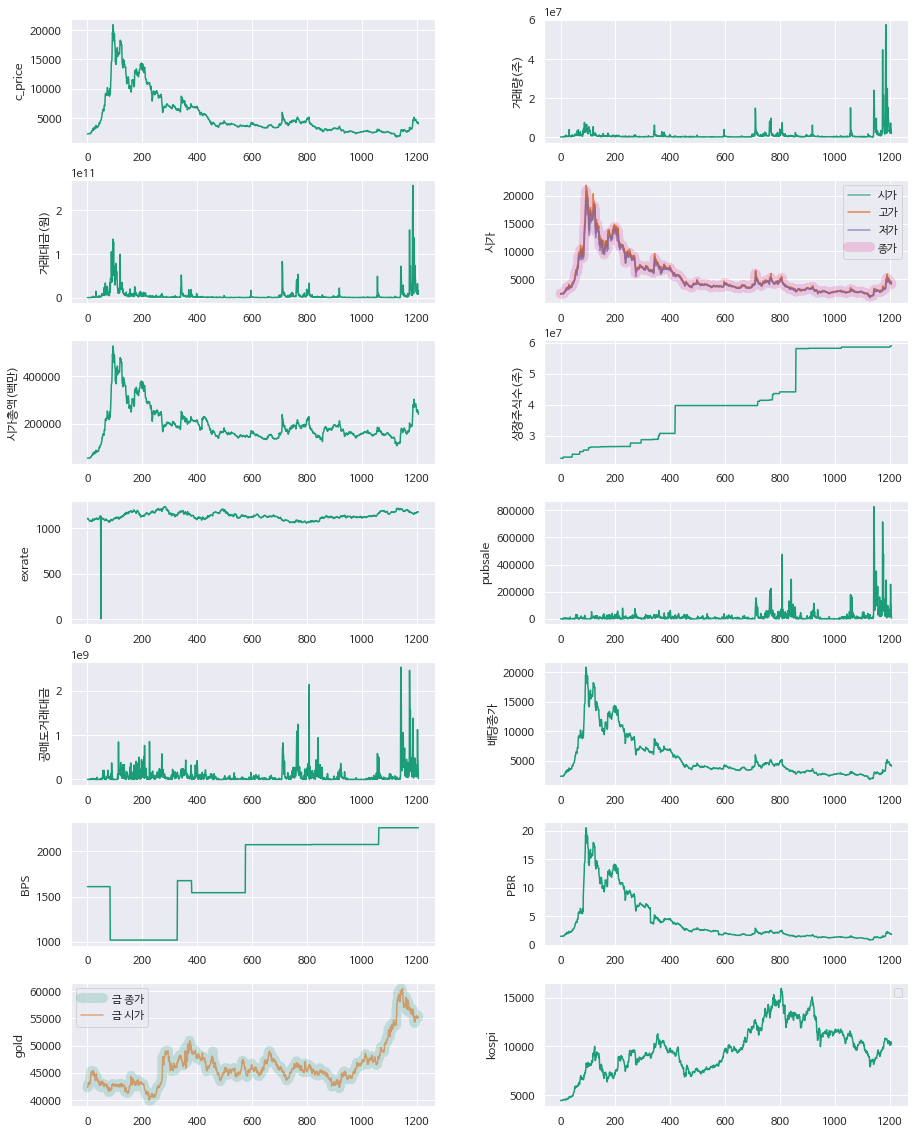

In [16]:
sns.set_palette("Dark2")

f, ax = plt.subplots(7, 2, figsize=(15, 20))

sns.lineplot(data=a6['c_price'], ax=ax[0][0])
sns.lineplot(data=a6['거래량(주)'], ax=ax[0][1])
sns.lineplot(data=a6['거래대금(원)'], ax=ax[1][0])
sns.lineplot(data=a6['시가'], ax=ax[1][1],label="시가",alpha = 0.7)
sns.lineplot(data=a6['고가'], ax=ax[1][1],label="고가",alpha = 0.7)
sns.lineplot(data=a6['저가'], ax=ax[1][1],label="저가",alpha = 0.7)
sns.lineplot(data=a6['c_price'],ax=ax[1][1],label="종가",linewidth=10,alpha = 0.2)
sns.lineplot(data=a6['시가총액(백만)'], ax=ax[2][0])
sns.lineplot(data=a6['상장주식수(주)'], ax=ax[2][1])
sns.lineplot(data=a6['exrate'], ax=ax[3][0])
sns.lineplot(data=a6['pubsale'], ax=ax[3][1])
sns.lineplot(data=a6['공매도거래대금'], ax=ax[4][0])
sns.lineplot(data=a6['배당종가'], ax=ax[4][1])
sns.lineplot(data=a6['BPS'], ax=ax[5][0])
sns.lineplot(data=a6['PBR'], ax=ax[5][1])
sns.lineplot(data=a6['gold'], ax=ax[6][0],label="금 종가",alpha = 0.2,linewidth=10)
sns.lineplot(data=a6['gold_start'], ax=ax[6][0],label="금 시가",alpha = 0.5)
sns.lineplot(data=a6['kospi'], ax=ax[6][1])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.legend()
plt.show()

In [17]:
a6.iloc[49]  # exrate가 1.1278

date           2015-03-17
c_price              4600
거래량(주)             376404
거래대금(원)       1.72252e+09
시가                   4650
고가                   4660
저가                   4490
시가총액(백만)           110274
상장주식수(주)      2.39727e+07
exrate             1.1278
pubsale              1176
공매도거래대금       5.41136e+06
배당종가                 4600
BPS                  1610
PBR                  2.86
gold                42700
gold_start          43100
kospi             5333.94
Name: 49, dtype: object

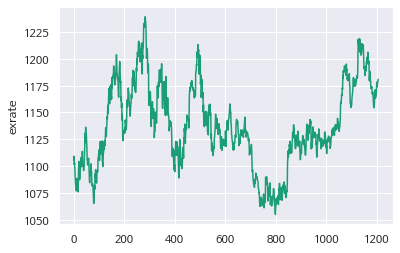

In [18]:
a6['exrate'][49] = 1127.8

sns.lineplot(data=a6['exrate'])

# 시계열 분석

## (1) 파생변수 생성

In [19]:
a6['date']=pd.to_datetime(a6['date'])
a6.index=a6['date']
time_data=a6

In [20]:
time_data['Year'] = time_data['date'].dt.year
time_data['Quarter'] = time_data['date'].dt.quarter
time_data['Quater_ver2'] = time_data['Quarter'] + (time_data.Year - time_data.Year.min()) * 4
time_data['DayofWeek'] = time_data['date'].dt.dayofweek

time_data['Month'] = time_data['date'].dt.month
time_data['count_lag1'] = time_data['c_price'].shift(1)
time_data['count_lag2'] = time_data['c_price'].shift(2)
time_data['count_lag1'].fillna(method='bfill', inplace=True)
time_data['count_lag2'].fillna(method='bfill', inplace=True)

time_data

,date,c_price,거래량(주),거래대금(원),시가,고가,저가,시가총액(백만),상장주식수(주),exrate,pubsale,공매도거래대금,배당종가,BPS,PBR,gold,gold_start,kospi,Year,Quarter,Quater_ver2,DayofWeek,Month,count_lag1,count_lag2
date,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,2015-01-02,2350.0,131029.0,3.064134e+08,2280.0,2400.0,2280.0,53279.0,22671867.0,1105.65,61.0,1.419700e+05,2350.0,1610.0,1.46,42300.0,42300.0,4464.08,2015,1,1,4,1,2350.0,2350.0
2015-01-05,2015-01-05,2340.0,83185.0,1.937542e+08,2370.0,2385.0,2280.0,53052.0,22671867.0,1109.18,723.0,1.686620e+06,2340.0,1610.0,1.45,42680.0,42400.0,4481.14,2015,1,1,0,1,2350.0,2350.0
2015-01-06,2015-01-06,2380.0,72097.0,1.687488e+08,2300.0,2380.0,2300.0,53959.0,22671867.0,1101.65,315.0,7.391900e+05,2380.0,1610.0,1.48,42710.0,42700.0,4468.42,2015,1,1,1,1,2340.0,2350.0
2015-01-07,2015-01-07,2395.0,81393.0,1.953211e+08,2395.0,2420.0,2375.0,54299.0,22671867.0,1103.25,520.0,1.245855e+06,2395.0,1610.0,1.49,42970.0,43190.0,4450.86,2015,1,1,2,1,2380.0,2340.0
2015-01-08,2015-01-08,2390.0,60837.0,1.452567e+08,2400.0,2415.0,2370.0,54186.0,22671867.0,1097.35,187.0,4.470000e+05,2390.0,1610.0,1.48,42890.0,43000.0,4445.84,2015,1,1,3,1,2395.0,2380.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-25,2019-11-25,4220.0,1908892.0,8.178295e+09,4295.0,4385.0,4210.0,248955.0,58994130.0,1173.94,46059.0,1.974867e+08,4220.0,2261.0,1.87,55150.0,55340.0,10343.65,2019,4,20,0,11,4260.0,4320.0
2019-11-26,2019-11-26,4390.0,7224166.0,3.198747e+10,4225.0,4610.0,4225.0,258984.0,58994130.0,1176.97,255034.0,1.126076e+09,4390.0,2261.0,1.94,55110.0,54990.0,10343.92,2019,4,20,1,11,4220.0,4260.0
2019-11-27,2019-11-27,4235.0,2675268.0,1.156499e+10,4395.0,4470.0,4235.0,249840.0,58994130.0,1178.00,110546.0,4.784162e+08,4235.0,2261.0,1.87,55220.0,55290.0,10485.23,2019,4,20,2,11,4390.0,4220.0


## (2) Train, Test data

In [42]:
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test


Y_colname = ['c_price']
X_remove = ['date','배당종가']
X_colname = [x for x in time_data.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test  = datasplit_ts(time_data,Y_colname,X_colname,'2019-11-25')


X_train_op, X_val_op, Y_train_op, Y_val_op = datasplit_ts(time_data,Y_colname,X_colname,'2019-11-18')
X_val_op,Y_val_op = X_val_op.iloc[:5],Y_val_op.iloc[:5]


Train_size: (1202, 25) Test_size: (5, 25)
X_train: (1202, 22) Y_train: (1202, 1)
X_test: (5, 22) Y_test: (5, 1)
Train_size: (1197, 25) Test_size: (10, 25)
X_train: (1197, 22) Y_train: (1197, 1)
X_test: (10, 22) Y_test: (10, 1)


In [43]:
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_X_op = preprocessing.MinMaxScaler()

In [44]:
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = Y_train
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = Y_test

In [45]:
X_train_op = scaler_X_op.fit_transform(X_train_op)
X_val_op = scaler_X_op.transform(X_val_op)

In [46]:
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual


def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

- hyperparameter 튜닝 (Optuna)

In [91]:
def objectiveXGB(trial: Trial) :
    params = {
        "random_state": 42,
        "learning_rate": trial.suggest_loguniform('learning_rate' ,1e-3, 1e-1),
        "n_estimators": trial.suggest_int('n_estimators',100,1000),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
    }
    
    model = XGBRegressor(**params)
    model.fit(
        X_train_op,
        Y_train_op,
        eval_set=[(X_train_op, Y_train_op), (X_val_op, Y_val_op)],
        early_stopping_rounds=100,
        verbose=False,
    )

    xgb_pred = model.predict(X_val_op)
    score = mean_squared_error(Y_val_op, xgb_pred)
    
    return score


sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler)

study.optimize(objectiveXGB, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-27 14:01:43,347] A new study created in memory with name: xgb_parameter_opt


[14:01:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:45,028] Trial 0 finished with value: 1447.7516218662263 and parameters: {'learning_rate': 0.005611516415334507, 'n_estimators': 956, 'max_depth': 15, 'colsample_bytree': 0.759195090518222, 'subsample': 0.40921304830970556, 'min_child_weight': 47}. Best is trial 0 with value: 1447.7516218662263.


[14:01:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:46,598] Trial 1 finished with value: 616511.7695675492 and parameters: {'learning_rate': 0.0013066739238053278, 'n_estimators': 880, 'max_depth': 13, 'colsample_bytree': 0.8248435466776274, 'subsample': 0.3144091460070617, 'min_child_weight': 291}. Best is trial 0 with value: 1447.7516218662263.


[14:01:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:46,889] Trial 2 finished with value: 40678.7193377018 and parameters: {'learning_rate': 0.04622589001020832, 'n_estimators': 291, 'max_depth': 4, 'colsample_bytree': 0.5100427059120604, 'subsample': 0.5129695700716763, 'min_child_weight': 158}. Best is trial 0 with value: 1447.7516218662263.


[14:01:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:47,710] Trial 3 finished with value: 26800.238151884078 and parameters: {'learning_rate': 0.007309539835912915, 'n_estimators': 362, 'max_depth': 13, 'colsample_bytree': 0.4836963163912251, 'subsample': 0.5045012539746527, 'min_child_weight': 110}. Best is trial 0 with value: 1447.7516218662263.


[14:01:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:49,268] Trial 4 finished with value: 571.7373285293579 and parameters: {'learning_rate': 0.008168455894760165, 'n_estimators': 807, 'max_depth': 4, 'colsample_bytree': 0.708540663048167, 'subsample': 0.7146901982034297, 'min_child_weight': 14}. Best is trial 4 with value: 571.7373285293579.


[14:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:49,700] Trial 5 finished with value: 30190.05439629555 and parameters: {'learning_rate': 0.016409286730647923, 'n_estimators': 253, 'max_depth': 2, 'colsample_bytree': 0.9693313223519999, 'subsample': 0.9759424231521916, 'min_child_weight': 243}. Best is trial 4 with value: 571.7373285293579.


[14:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:50,098] Trial 6 finished with value: 3730081.297617507 and parameters: {'learning_rate': 0.0040665633135147945, 'n_estimators': 188, 'max_depth': 14, 'colsample_bytree': 0.6640914962437607, 'subsample': 0.38542676439134516, 'min_child_weight': 149}. Best is trial 4 with value: 571.7373285293579.


[14:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:52,229] Trial 7 finished with value: 514688.04540430306 and parameters: {'learning_rate': 0.001171593739230706, 'n_estimators': 919, 'max_depth': 6, 'colsample_bytree': 0.7975133706123891, 'subsample': 0.5181977532625877, 'min_child_weight': 157}. Best is trial 4 with value: 571.7373285293579.


[14:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:52,749] Trial 8 finished with value: 38210.03304767609 and parameters: {'learning_rate': 0.0123999678368461, 'n_estimators': 266, 'max_depth': 20, 'colsample_bytree': 0.8650796940166687, 'subsample': 0.9576492590949324, 'min_child_weight': 269}. Best is trial 4 with value: 571.7373285293579.


[14:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:53,141] Trial 9 finished with value: 37725.77298736572 and parameters: {'learning_rate': 0.015696396388661146, 'n_estimators': 930, 'max_depth': 2, 'colsample_bytree': 0.5175897174514872, 'subsample': 0.33165910223737666, 'min_child_weight': 98}. Best is trial 4 with value: 571.7373285293579.


[14:01:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:53,630] Trial 10 finished with value: 1759.3411299705506 and parameters: {'learning_rate': 0.0843164577397743, 'n_estimators': 708, 'max_depth': 7, 'colsample_bytree': 0.6559930962084657, 'subsample': 0.8006187285377566, 'min_child_weight': 7}. Best is trial 4 with value: 571.7373285293579.


[14:01:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:55,709] Trial 11 finished with value: 172064.02215510607 and parameters: {'learning_rate': 0.0032425517614221764, 'n_estimators': 697, 'max_depth': 19, 'colsample_bytree': 0.7319387651769488, 'subsample': 0.7449433813607633, 'min_child_weight': 14}. Best is trial 4 with value: 571.7373285293579.


[14:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:57,732] Trial 12 finished with value: 16423.36423172951 and parameters: {'learning_rate': 0.004186883840510776, 'n_estimators': 742, 'max_depth': 17, 'colsample_bytree': 0.6209786706637112, 'subsample': 0.668224095312702, 'min_child_weight': 57}. Best is trial 4 with value: 571.7373285293579.


[14:01:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:58,675] Trial 13 finished with value: 686.6381571769714 and parameters: {'learning_rate': 0.029888008228755973, 'n_estimators': 514, 'max_depth': 9, 'colsample_bytree': 0.9913272298120274, 'subsample': 0.881362302658839, 'min_child_weight': 47}. Best is trial 4 with value: 571.7373285293579.


[14:01:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:01:59,707] Trial 14 finished with value: 1507.9939051628112 and parameters: {'learning_rate': 0.032281156259751836, 'n_estimators': 473, 'max_depth': 9, 'colsample_bytree': 0.9933578731577521, 'subsample': 0.8536646040520228, 'min_child_weight': 4}. Best is trial 4 with value: 571.7373285293579.


[14:01:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:00,763] Trial 15 finished with value: 521.1510699272155 and parameters: {'learning_rate': 0.028228964086860545, 'n_estimators': 552, 'max_depth': 9, 'colsample_bytree': 0.9055025740780626, 'subsample': 0.8872917860523398, 'min_child_weight': 55}. Best is trial 15 with value: 521.1510699272155.


[14:02:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:01,165] Trial 16 finished with value: 5388.870256996155 and parameters: {'learning_rate': 0.08875511724692428, 'n_estimators': 633, 'max_depth': 5, 'colsample_bytree': 0.8935209602476667, 'subsample': 0.6838849844375581, 'min_child_weight': 85}. Best is trial 15 with value: 521.1510699272155.


[14:02:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:01,945] Trial 17 finished with value: 567.6334931850433 and parameters: {'learning_rate': 0.023264460065759652, 'n_estimators': 809, 'max_depth': 9, 'colsample_bytree': 0.577572408413855, 'subsample': 0.5938809144458327, 'min_child_weight': 30}. Best is trial 15 with value: 521.1510699272155.


[14:02:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:02,240] Trial 18 finished with value: 38489.117878198624 and parameters: {'learning_rate': 0.04311660790907897, 'n_estimators': 590, 'max_depth': 11, 'colsample_bytree': 0.4124198070634534, 'subsample': 0.5816991526515977, 'min_child_weight': 213}. Best is trial 15 with value: 521.1510699272155.


[14:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:02,858] Trial 19 finished with value: 7238.491327619553 and parameters: {'learning_rate': 0.02390590259420457, 'n_estimators': 465, 'max_depth': 10, 'colsample_bytree': 0.5757034382624481, 'subsample': 0.6059500008835149, 'min_child_weight': 67}. Best is trial 15 with value: 521.1510699272155.


[14:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:03,225] Trial 20 finished with value: 46145.50967360735 and parameters: {'learning_rate': 0.047984866304561516, 'n_estimators': 817, 'max_depth': 8, 'colsample_bytree': 0.5802043784322503, 'subsample': 0.778155271164355, 'min_child_weight': 133}. Best is trial 15 with value: 521.1510699272155.


[14:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:05,168] Trial 21 finished with value: 576.6338548183442 and parameters: {'learning_rate': 0.00906021212827584, 'n_estimators': 810, 'max_depth': 11, 'colsample_bytree': 0.9204270360146245, 'subsample': 0.7068281449722851, 'min_child_weight': 21}. Best is trial 15 with value: 521.1510699272155.


[14:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:05,750] Trial 22 finished with value: 946.6816492080688 and parameters: {'learning_rate': 0.019523401839247334, 'n_estimators': 997, 'max_depth': 3, 'colsample_bytree': 0.4047841921241534, 'subsample': 0.9061481815544549, 'min_child_weight': 35}. Best is trial 15 with value: 521.1510699272155.


[14:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:06,674] Trial 23 finished with value: 1893.400101184845 and parameters: {'learning_rate': 0.011663843442191913, 'n_estimators': 815, 'max_depth': 6, 'colsample_bytree': 0.710637753088784, 'subsample': 0.5905223317059498, 'min_child_weight': 78}. Best is trial 15 with value: 521.1510699272155.


[14:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:08,275] Trial 24 finished with value: 980029.7068140864 and parameters: {'learning_rate': 0.0023372928569047836, 'n_estimators': 629, 'max_depth': 7, 'colsample_bytree': 0.4558882431417132, 'subsample': 0.6367428065878137, 'min_child_weight': 3}. Best is trial 15 with value: 521.1510699272155.


[14:02:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:10,043] Trial 25 finished with value: 752.4868625164032 and parameters: {'learning_rate': 0.007311051847039388, 'n_estimators': 756, 'max_depth': 12, 'colsample_bytree': 0.5611881265649352, 'subsample': 0.8301880891300408, 'min_child_weight': 24}. Best is trial 15 with value: 521.1510699272155.


[14:02:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:10,397] Trial 26 finished with value: 24758.846460437773 and parameters: {'learning_rate': 0.05769477180078327, 'n_estimators': 866, 'max_depth': 4, 'colsample_bytree': 0.6595585003247464, 'subsample': 0.7217584508643685, 'min_child_weight': 116}. Best is trial 15 with value: 521.1510699272155.


[14:02:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:11,303] Trial 27 finished with value: 594.462729215622 and parameters: {'learning_rate': 0.02523527586845677, 'n_estimators': 398, 'max_depth': 9, 'colsample_bytree': 0.7769048543930004, 'subsample': 0.9385478353303521, 'min_child_weight': 41}. Best is trial 15 with value: 521.1510699272155.


[14:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:11,715] Trial 28 finished with value: 82283.68787599802 and parameters: {'learning_rate': 0.018301085974794767, 'n_estimators': 557, 'max_depth': 1, 'colsample_bytree': 0.8443435908398043, 'subsample': 0.4616989546874646, 'min_child_weight': 195}. Best is trial 15 with value: 521.1510699272155.


[14:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:12,328] Trial 29 finished with value: 8639.456411504745 and parameters: {'learning_rate': 0.06837843839811969, 'n_estimators': 987, 'max_depth': 16, 'colsample_bytree': 0.744500891873773, 'subsample': 0.7543826928148194, 'min_child_weight': 56}. Best is trial 15 with value: 521.1510699272155.


[14:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:12,665] Trial 30 finished with value: 2158.906233930588 and parameters: {'learning_rate': 0.035528183684717635, 'n_estimators': 100, 'max_depth': 7, 'colsample_bytree': 0.9331222094178325, 'subsample': 0.6350187757544575, 'min_child_weight': 33}. Best is trial 15 with value: 521.1510699272155.


[14:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:15,223] Trial 31 finished with value: 775.4408704280853 and parameters: {'learning_rate': 0.007349599234881101, 'n_estimators': 797, 'max_depth': 11, 'colsample_bytree': 0.9076026241953918, 'subsample': 0.7037915946098872, 'min_child_weight': 1}. Best is trial 15 with value: 521.1510699272155.


[14:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:16,916] Trial 32 finished with value: 892.1077358722687 and parameters: {'learning_rate': 0.010059896310773865, 'n_estimators': 866, 'max_depth': 12, 'colsample_bytree': 0.8132789161913522, 'subsample': 0.8055342126446318, 'min_child_weight': 25}. Best is trial 15 with value: 521.1510699272155.


[14:02:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:18,639] Trial 33 finished with value: 8877.915903043748 and parameters: {'learning_rate': 0.005384335976437363, 'n_estimators': 662, 'max_depth': 10, 'colsample_bytree': 0.9414843756747182, 'subsample': 0.5376252772438679, 'min_child_weight': 77}. Best is trial 15 with value: 521.1510699272155.


[14:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:20,560] Trial 34 finished with value: 575.2108092784881 and parameters: {'learning_rate': 0.008846703323817352, 'n_estimators': 781, 'max_depth': 14, 'colsample_bytree': 0.8793550079073219, 'subsample': 0.4505174533547684, 'min_child_weight': 20}. Best is trial 15 with value: 521.1510699272155.


[14:02:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:21,494] Trial 35 finished with value: 2272.7574201107027 and parameters: {'learning_rate': 0.013591604395317772, 'n_estimators': 911, 'max_depth': 14, 'colsample_bytree': 0.8692394795744088, 'subsample': 0.44290447692010726, 'min_child_weight': 50}. Best is trial 15 with value: 521.1510699272155.


[14:02:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:22,833] Trial 36 finished with value: 14530.777459812165 and parameters: {'learning_rate': 0.005471695639964229, 'n_estimators': 755, 'max_depth': 17, 'colsample_bytree': 0.7659796816348861, 'subsample': 0.3966683146243247, 'min_child_weight': 65}. Best is trial 15 with value: 521.1510699272155.


[14:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:23,329] Trial 37 finished with value: 29214.75135011673 and parameters: {'learning_rate': 0.02342686333837007, 'n_estimators': 692, 'max_depth': 14, 'colsample_bytree': 0.6195719913410768, 'subsample': 0.5381505145411039, 'min_child_weight': 90}. Best is trial 15 with value: 521.1510699272155.


[14:02:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:25,663] Trial 38 finished with value: 682243.8585225344 and parameters: {'learning_rate': 0.0019561629755364307, 'n_estimators': 862, 'max_depth': 13, 'colsample_bytree': 0.9632223077756619, 'subsample': 0.3251404289656566, 'min_child_weight': 1}. Best is trial 15 with value: 521.1510699272155.


[14:02:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:26,407] Trial 39 finished with value: 21722.097652959823 and parameters: {'learning_rate': 0.009146778370165204, 'n_estimators': 359, 'max_depth': 5, 'colsample_bytree': 0.6990664506743816, 'subsample': 0.46948867414119544, 'min_child_weight': 111}. Best is trial 15 with value: 521.1510699272155.


[14:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:27,482] Trial 40 finished with value: 889.4838656425476 and parameters: {'learning_rate': 0.013396663405861474, 'n_estimators': 951, 'max_depth': 16, 'colsample_bytree': 0.5319045115810718, 'subsample': 0.9881574998077699, 'min_child_weight': 37}. Best is trial 15 with value: 521.1510699272155.


[14:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:29,509] Trial 41 finished with value: 671.3209767341614 and parameters: {'learning_rate': 0.008545514054777976, 'n_estimators': 809, 'max_depth': 12, 'colsample_bytree': 0.9057536817819817, 'subsample': 0.5597333003206163, 'min_child_weight': 19}. Best is trial 15 with value: 521.1510699272155.


[14:02:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:32,072] Trial 42 finished with value: 538.3127766132354 and parameters: {'learning_rate': 0.006383955361345092, 'n_estimators': 771, 'max_depth': 15, 'colsample_bytree': 0.8699487565143507, 'subsample': 0.624364839738793, 'min_child_weight': 18}. Best is trial 15 with value: 521.1510699272155.


[14:02:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:34,308] Trial 43 finished with value: 18300.746984624864 and parameters: {'learning_rate': 0.00427558409711022, 'n_estimators': 734, 'max_depth': 15, 'colsample_bytree': 0.8350118152600595, 'subsample': 0.49829121527234993, 'min_child_weight': 15}. Best is trial 15 with value: 521.1510699272155.


[14:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:36,431] Trial 44 finished with value: 4274.620256900787 and parameters: {'learning_rate': 0.006218121139377006, 'n_estimators': 656, 'max_depth': 18, 'colsample_bytree': 0.8846222548459538, 'subsample': 0.6227734231504904, 'min_child_weight': 44}. Best is trial 15 with value: 521.1510699272155.


[14:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:37,476] Trial 45 finished with value: 2830.191252660751 and parameters: {'learning_rate': 0.0115964401641741, 'n_estimators': 895, 'max_depth': 15, 'colsample_bytree': 0.7968423458333732, 'subsample': 0.5689594274764948, 'min_child_weight': 64}. Best is trial 15 with value: 521.1510699272155.


[14:02:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:39,171] Trial 46 finished with value: 885.010772228241 and parameters: {'learning_rate': 0.014992012860229557, 'n_estimators': 776, 'max_depth': 13, 'colsample_bytree': 0.8568346608935095, 'subsample': 0.5015211327224324, 'min_child_weight': 34}. Best is trial 15 with value: 521.1510699272155.


[14:02:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:40,250] Trial 47 finished with value: 349129.5988797188 and parameters: {'learning_rate': 0.003527548807820901, 'n_estimators': 714, 'max_depth': 8, 'colsample_bytree': 0.4810893354377121, 'subsample': 0.6706628598766472, 'min_child_weight': 300}. Best is trial 15 with value: 521.1510699272155.


[14:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:41,360] Trial 48 finished with value: 25650.992575263976 and parameters: {'learning_rate': 0.006413605483993644, 'n_estimators': 575, 'max_depth': 1, 'colsample_bytree': 0.9600414493918422, 'subsample': 0.651942674187582, 'min_child_weight': 11}. Best is trial 15 with value: 521.1510699272155.


[14:02:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-27 14:02:43,955] Trial 49 finished with value: 4073.2400126457214 and parameters: {'learning_rate': 0.00473195235186126, 'n_estimators': 830, 'max_depth': 20, 'colsample_bytree': 0.8033135079189037, 'subsample': 0.7378801682284103, 'min_child_weight': 51}. Best is trial 15 with value: 521.1510699272155.


Best Score: 521.1510699272155
Best trial: {'learning_rate': 0.028228964086860545, 'n_estimators': 552, 'max_depth': 9, 'colsample_bytree': 0.9055025740780626, 'subsample': 0.8872917860523398, 'min_child_weight': 55}


In [92]:
optuna.visualization.plot_param_importances(study)


- 매 시도마다 감소한 loss 확인

In [93]:
optuna.visualization.plot_optimization_history(study)

In [94]:
xgb_params=study.best_trial.params
xgb_params

{'colsample_bytree': 0.9055025740780626,
 'learning_rate': 0.028228964086860545,
 'max_depth': 9,
 'min_child_weight': 55,
 'n_estimators': 552,
 'subsample': 0.8872917860523398}

In [95]:
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train_scaled, Y_train_scaled)
Y_train_pred = xgb.predict(X_train_scaled)
Y_test_pred = xgb.predict(X_test_scaled)

[14:02:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [96]:
Score_xgb, Residual_tr, Residual_te = evaluation_trte(Y_train_scaled, Y_train_pred, Y_test_scaled, Y_test_pred, graph_on=False)

display(Score_xgb)

,MAE,MSE,MAPE
Train,84.877042,65843.994752,1.119865
Test,120.761182,17667.924958,2.874562


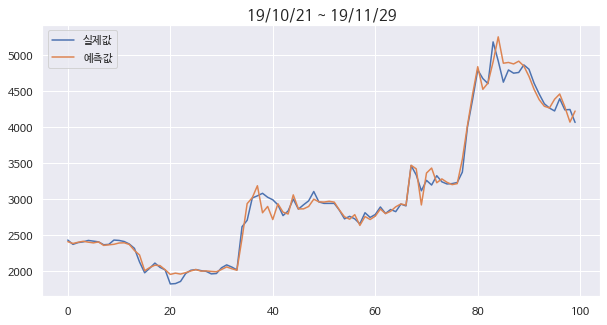

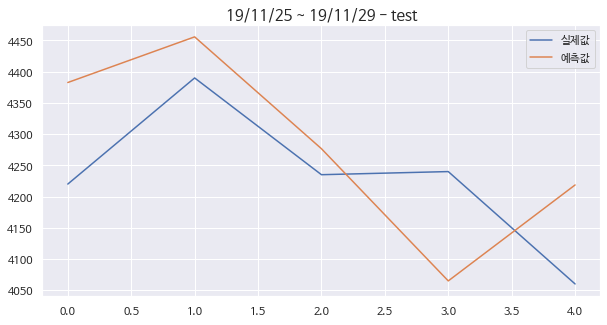

In [185]:
pr=np.append(Y_train_pred,Y_test_pred)
sc=pd.concat([Y_train_scaled,Y_test_scaled])

f, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=sc.values[-100:].flatten(),ax=ax,label="실제값")
sns.lineplot(data=pr[-100:],ax=ax,label="예측값")
plt.title('19/10/21 ~ 19/11/29', fontsize=15)



f, ax = plt.subplots(figsize=(10, 5))

plt.title('19/11/25 ~ 19/11/29 - test', fontsize=15)
sns.lineplot(data=Y_test_scaled.values.flatten(),ax=ax,label="실제값")
sns.lineplot(data=Y_test_pred,ax=ax,label="예측값")

plt.legend()
plt.show()


GRU는 기존 LSTM에 비해 더 간단한 구조를 가지고 있습니다. 그리고 마지막 출력값에 활성화함수를 적용하지 않습니다. 성능 면에서는 LSTM과 비교해서 우월하다고 할 수 없지만 학습할 파라미터가 더 적은 것이 장점이라고 할 수 있습니다.

- sequence size

In [189]:
Score = dict()
epoch = 20
verbose = 0
dropout_ratio = 0
batch_size = 10

seqsize_list = [i for i in range(1, 5, 1)]

for i in tqdm(seqsize_list):
    sequence = i

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train) # sequence 크기의 데이터
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence])) 
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) # sequence 크기의 데이터

    ## Retype and Reshape
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu')) #sequence, 열 갯수
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)

    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
    display(Score_GRU)
    Score[str(sequence)] = Score_GRU


  0%|          | 0/4 [00:00<?, ?it/s]

X_train: (1201, 1, 22) Y_train: (1201, 1)
X_test: (4, 1, 22) Y_test: (4, 1)
1/1 [==============================] - 2s 2s/step - loss: 1.4901e-08


,MAE,MSE,MAPE
Train,223.208810,161073.122542,4.024726
Test,332.567322,125918.068662,7.785035



 25%|██▌       | 1/4 [00:25<01:16, 25.49s/it]

X_train: (1200, 2, 22) Y_train: (1200, 1)
X_test: (3, 2, 22) Y_test: (3, 1)
1/1 [==============================] - 2s 2s/step - loss: 1.5895e-07


,MAE,MSE,MAPE
Train,271.548482,224158.971824,5.030333
Test,133.128418,25380.207933,3.145058



 50%|█████     | 2/4 [00:52<00:52, 26.06s/it]

X_train: (1199, 3, 22) Y_train: (1199, 1)
X_test: (2, 3, 22) Y_test: (2, 1)
1/1 [==============================] - 2s 2s/step - loss: 2.9802e-08


,MAE,MSE,MAPE
Train,271.514756,232129.708830,4.658365
Test,277.448242,83676.046396,6.645856



 75%|███████▌  | 3/4 [01:32<00:30, 30.20s/it]

X_train: (1198, 4, 22) Y_train: (1198, 1)
X_test: (1, 4, 22) Y_test: (1, 1)
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,335.176301,306703.626111,6.140226
Test,124.602051,15525.671059,3.069016



100%|██████████| 4/4 [02:17<00:00, 34.35s/it]


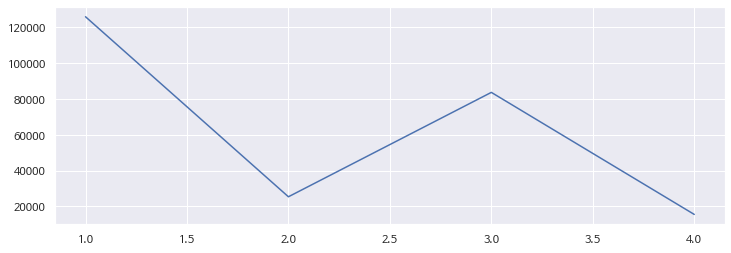

In [190]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show() #4

In [ ]:
sequence = 4
epoch = 20
verbose = 0
dropout_ratio = 0


Score = dict()
batchsize_list = [i for i in range(5, 50, 5)]
for i in tqdm(batchsize_list):
    batch_size = i

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    ## Retype and Reshape
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    # plt.plot(pd.DataFrame(model_fit.history))
    # plt.grid(True)
    # plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
                                                          
    Score[str(batch_size)] = Score_GRU




  0%|          | 0/9 [00:00<?, ?it/s]

X_train: (1198, 4, 22) Y_train: (1198, 1)
X_test: (1, 4, 22) Y_test: (1, 1)
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00




 11%|█         | 1/9 [01:11<09:30, 71.37s/it]

X_train: (1198, 4, 22) Y_train: (1198, 1)
X_test: (1, 4, 22) Y_test: (1, 1)
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00




 22%|██▏       | 2/9 [01:55<07:23, 63.32s/it]

X_train: (1198, 4, 22) Y_train: (1198, 1)
X_test: (1, 4, 22) Y_test: (1, 1)


In [ ]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = batchsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show() #35